In [7]:
!pip3 install gym keras gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#드라이브 미사용시 사용X
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base_path = './'
EPISODES = 4000
SEED = 12

In [17]:
import gym
import os
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym.wrappers.record_video import RecordVideo
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_size, action_size):
        # Cartpole이 학습하는 것을 보려면 "True"로 바꿀 것
        self.render = True

        # state와 action의 크기를 가져와서 모델을 생성하는데 사용함
        self.state_size = state_size
        self.action_size = action_size

        # Cartpole DQN 학습의 Hyper parameter 들
        # deque를 통해서 replay memory 생성
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=10000)

        # 학습할 모델과 타겟 모델을 생성
        self.model = self.build_model()
        self.target_model = self.build_model()
        # 학습할 모델을 타겟 모델로 복사 --> 타겟 모델의 초기화(weight를 같게 해주고 시작해야 함)
        self.update_target_model()

    # Deep Neural Network를 통해서 Q Function을 근사
    # state가 입력, 각 행동에 대한 Q Value가 출력인 모델을 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 일정한 시간 간격마다 타겟 모델을 현재 학습하고 있는 모델로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 행동의 선택은 현재 네트워크에 대해서 epsilon-greedy 정책을 사용
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # <state, action, reward, next_state>을 replay_memory에 저장함
    def replay_memory(self, state, action, reward, next_state, done):
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay 

    def getReward(self, state):
        # 리워드 보상 함수
        # 0.5 이상인 경우 Goal에 도착했다고 판단
        if state[0] >= 0.5:
          return 10
        if state[0] > -0.4:
          return (1 + state[0]) ** 2
        return 0

    # replay memory에서 batch_size 만큼의 샘플들을 무작위로 뽑아서 학습
    def train_replay(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            # 큐러닝에서와 같이 s'에서의 최대 Q Value를 가져옴. 단, 타겟 모델에서 가져옴
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        # 학습할 정답인 타겟과 현재 자신의 값의 minibatch를 만들고 그것으로 한 번에 모델 업데이트
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    # 저장한 모델을 불러옴
    def load_model(self, name):
        self.model.load_weights(name)

    # 학습된 모델을 저장함
    def save_model(self, name):
        self.model.save_weights(name)

In [13]:
def plot(steps):
    ax = plt.subplot(111)
    ax.cla()
    ax.set_title('Training')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Run Time')
    ax.plot(steps)
    RunTime = len(steps)
    path =  base_path + 'graph/RunTime'+str(RunTime)+'.jpg'
    plt.savefig(path)
    plt.pause(0.0000001)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 32)                96        
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 2)                 34        
                                                                 
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 32)                96        
                                                                 
 dense_40 (Dense)            (No

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/대학원_강의/2022_하반기/강화학습의 기초/과제/dqn/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning

[[-0.5498351  0.       ]]


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more inform

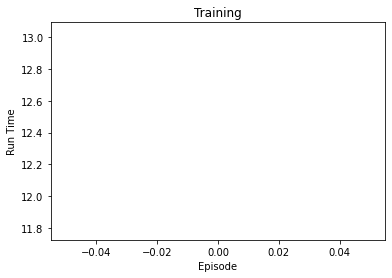

episode: 0   score: 12.40923331931804   memory length: 200   epsilon: 0.9960200000000077
model save : -200
[[-0.56213593  0.        ]]


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as depreca

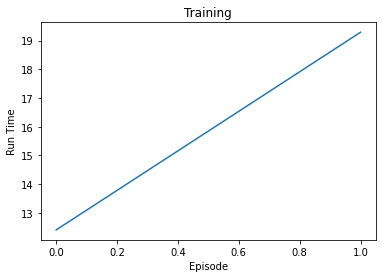

episode: 1   score: 19.289942178648033   memory length: 400   epsilon: 0.9920400000000154
model save : 12.40923331931804
[[-0.53002214  0.        ]]


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as depreca

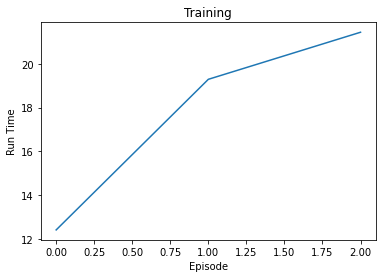

episode: 2   score: 21.439922896246987   memory length: 600   epsilon: 0.988060000000023
model save : 19.289942178648033
[[-0.46591085  0.        ]]


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 16ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


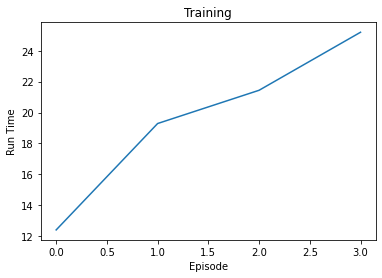

episode: 3   score: 25.192932268631573   memory length: 800   epsilon: 0.9840800000000307
model save : 21.439922896246987
[[-0.42073813  0.        ]]


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


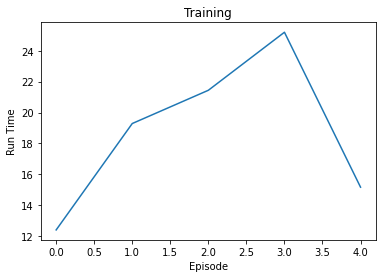

episode: 4   score: 15.173595248459002   memory length: 1000   epsilon: 0.9801000000000384
[[-0.5994346  0.       ]]
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 94ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


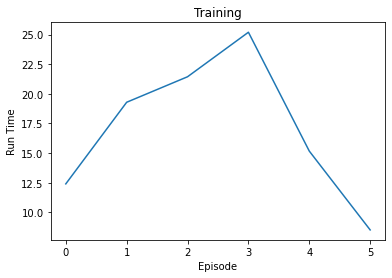

episode: 5   score: 8.528063646340494   memory length: 1200   epsilon: 0.9761200000000461
[[-0.57862973  0.        ]]
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


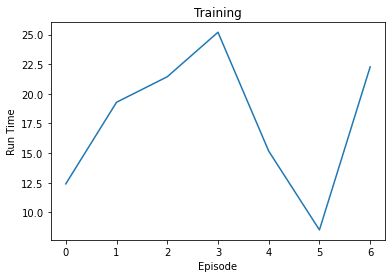

episode: 6   score: 22.271060317168274   memory length: 1400   epsilon: 0.9721400000000537
[[-0.5166208  0.       ]]
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


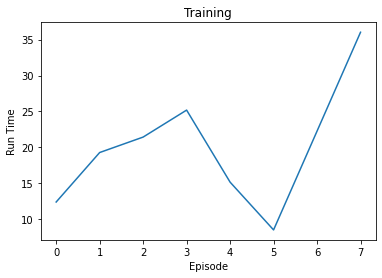

episode: 7   score: 36.02016411115028   memory length: 1600   epsilon: 0.9681600000000614
model save : 25.192932268631573
[[-0.50637066  0.        ]]
1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


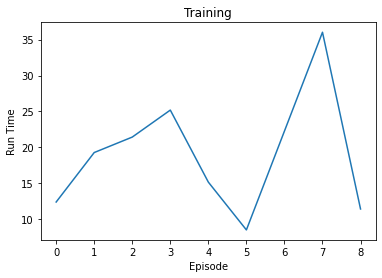

episode: 8   score: 11.439946331472164   memory length: 1800   epsilon: 0.9641800000000691
[[-0.5482458  0.       ]]
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


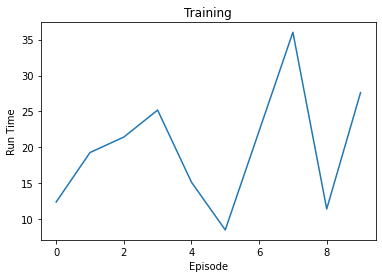

episode: 9   score: 27.61860389860378   memory length: 2000   epsilon: 0.9602000000000768
[[-0.46589792  0.        ]]
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCar-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


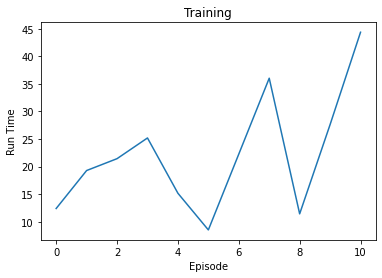

episode: 10   score: 44.35147728977275   memory length: 2200   epsilon: 0.9562200000000844
model save : 36.02016411115028
[[-0.41543782  0.        ]]
1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - ETA: 0s

In [ ]:
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

env = gym.make('MountainCar-v0')
env = RecordVideo(env, base_path + 'video',  episode_trigger = lambda episode_number: True)

env.action_space.seed(SEED)
env.seed(SEED)

# 환경으로부터 상태와 행동의 크기를 가져오기
state_size = env.observation_space.shape[0]

#action을 2개만 사용하기
action_size = 2

# DQN 에이전트의 생성
agent = DQNAgent(state_size, action_size)

#마지막 학습한 모델 로딩하기
agent.load_model(base_path + "save_model/MountainCar_DQN_10_44.35147728977275.h5")
scores, episodes = [], []

#reward check
last_reward = -200

for e in range(EPISODES):
  done = False
  score = 0
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  print(state)

  # action 0(좌), 1(아무것도 안함), 3(아무것도 하지 않는 액션을 하지 않기 위한 fake_action 선언
  fake_action = 0

  # 같은 액션을 4번하기 위한 카운터
  action_count = 0

  while not done:
    if agent.render:
      env.render()
      
    # 현재 상태에서 행동을 선택하고 한 스텝을 진행
    action_count = action_count + 1
    
    if action_count == 4:
      action = agent.get_action(state)
      action_count = 0
      
      if action == 0:
        fake_action = 0
      elif action == 1:
        fake_action = 2


    # 선택한 액션으로 1 step을 시행한다
    next_state, reward, done, info = env.step(fake_action)

    reward = agent.getReward(next_state)
    next_state = np.reshape(next_state, [1, state_size])
    
    # <state, action, reward, next state>을 replay memory에 저장
    agent.replay_memory(state, fake_action, reward, next_state, done)

    # 매 타임스텝마다 학습을 진행
    agent.train_replay()
    score += reward
    state = next_state
    
    if done:
      env.reset()
      
      # 매 에피소드마다 학습하는 모델을 타겟 모델로 복사
      agent.update_target_model()

      # 각 에피소드마다 cartpole이 서있었던 타임스텝을 plot
      scores.append(score)
      episodes.append(e)

      #그래프 그리기
      plot(scores)
      
      print("episode:" , e, "  score:", score, "  memory length:", len(agent.memory),"  epsilon:", agent.epsilon)

      # score값이 갱신되면 저장
      if score != -200 and last_reward < score:
        print(f'model save : {last_reward}')
        agent.save_model(base_path + "save_model/MountainCar_DQN_{}_{}.h5".format(str(e), str(score)))
        last_reward = score
